In [3]:
!pip install category_encoders umap shap optuna catboost missingpy miceforest --no-cache-dir

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
from itertools import combinations
import random
import gc
import time
import math

# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import seaborn as sns
from category_encoders import OrdinalEncoder, CountEncoder, CatBoostEncoder, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, LabelEncoder # OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.decomposition import PCA, NMF
#from umap import UMAP
from sklearn.decomposition import FastICA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
import shap

# Import libraries for Hypertuning
import optuna

# Import libraries for gradient boosting
import lightgbm as lgb
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process.kernels import RBF
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool
from matplotlib.ticker import MaxNLocator, MultipleLocator
import scipy.stats

from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, RFECV
from sklearn.inspection import permutation_importance

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', '.*DataFrame is highly fragmented*')


In [4]:
train_df = pd.read_csv("//kaggle/input/mlbuzz-beginner/train.csv")
test_df = pd.read_csv("/kaggle/input/mlbuzz-beginner/test.csv")
train_df.head()

,ID1,Specific ailments,ID2,Food preference,Age,BMI,Smoker?,Living in?,Any heriditary condition?,Follow Diet,Physical activity,Regular sleeping hours,Alcohol consumption,Social interaction,Taking supplements,Mental health management,Illness count last year,Healthy
0,2408,44,2668,DX6,49,20.500470,NO,RURAL,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,25063,39,10363,DX3 DX4,20,26.076580,NO,URBAN,Stable,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
2,26798,29,132,DX6,1,21.420866,NO,URBAN,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,31907,27,10499,DX1,30,25.203247,NO,RURAL,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,26412,9,7963,DX6,40,19.355846,YES,RURAL,Stable,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1


In [5]:
features = list(train_df.keys()[:-1])
features

['ID1',
 'Specific ailments',
 'ID2',
 'Food preference',
 'Age',
 'BMI',
 'Smoker?',
 'Living in?',
 'Any heriditary condition?',
 'Follow Diet',
 'Physical activity',
 'Regular sleeping hours',
 'Alcohol consumption',
 'Social interaction',
 'Taking supplements',
 'Mental health management',
 'Illness count last year']

In [6]:
def set_frame_style(df, caption=""):
    """Helper function to set dataframe presentation style."""
    return df.style.background_gradient(cmap='Blues', axis=0).set_caption(caption).set_table_styles([
        {
            'selector': 'caption',
            'props': [
                ('color', 'red'),
                ('font-size', '18px'),
                ('font-weight', 'bold')
            ]
        },
        {
            'selector': 'th',
            'props': [('font-weight', 'bold')]
        }
    ])

def check_data(data, title):
    cols = data.columns.to_list()
    summary_stats = data[cols].describe().T
    unique_value_counts = data[cols].nunique().to_frame().rename({0: 'Unique Count'}, axis=1).transpose().T
    columns_with_nan = data[cols].isna().sum().to_frame().rename({0: 'Nan Count'}, axis=1).transpose().T

    combined_stats = pd.concat([summary_stats, unique_value_counts, columns_with_nan], axis=1)

    display(set_frame_style(data[cols].head(), f'{title}: Head 5 Rows of Data'))
    display(set_frame_style(data[cols].tail(), f'{title}: Tail 5 Rows of Data'))
    display(set_frame_style(combined_stats, f'{title}: Summary Statistics, Unique Value Counts, and Columns With Nan'))

check_data(train_df, 'Train data')

,ID1,Specific ailments,ID2,Food preference,Age,BMI,Smoker?,Living in?,Any heriditary condition?,Follow Diet,Physical activity,Regular sleeping hours,Alcohol consumption,Social interaction,Taking supplements,Mental health management,Illness count last year,Healthy
0,2408,44,2668,DX6,49,20.500470,NO,RURAL,Stable,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1
1,25063,39,10363,DX3 DX4,20,26.076580,NO,URBAN,Stable,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1
2,26798,29,132,DX6,1,21.420866,NO,URBAN,Stable,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0
3,31907,27,10499,DX1,30,25.203247,NO,RURAL,Stable,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1
4,26412,9,7963,DX6,40,19.355846,YES,RURAL,Stable,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1


,ID1,Specific ailments,ID2,Food preference,Age,BMI,Smoker?,Living in?,Any heriditary condition?,Follow Diet,Physical activity,Regular sleeping hours,Alcohol consumption,Social interaction,Taking supplements,Mental health management,Illness count last year,Healthy
25915,69,12,818,DX6,58,25.515286,YES,RURAL,Stable,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1
25916,21001,39,11500,DX6,16,27.094959,NO,RURAL,Stable,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0
25917,4263,44,2796,DX1,8,28.602921,NO,RURAL,Stable,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1
25918,11208,52,12190,DX1,52,21.909832,NO,RURAL,Stable,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,1
25919,21535,17,8324,DX4,41,23.828813,NO,RURAL,Stable,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1


,count,mean,std,min,25%,50%,75%,max,Unique Count,Nan Count
ID1,25920.000000,16503.583989,9522.571120,1.000000,8251.750000,16531.500000,24701.500000,33014.000000,25920,0
Specific ailments,25920.000000,26.502701,15.056563,0.000000,13.000000,26.000000,40.000000,52.000000,53,0
ID2,25920.000000,6256.104282,3611.224659,1.000000,3151.000000,6246.000000,9391.250000,12515.000000,10941,0
Age,25920.000000,33.235610,19.532157,0.000000,16.000000,33.000000,50.000000,149.000000,76,0
BMI,25920.000000,23.461925,3.791150,1.145000,20.214882,23.415330,26.768378,29.999579,10941,0
Follow Diet,24947.000000,0.895739,0.305605,0.000000,1.000000,1.000000,1.000000,1.000000,2,973
Physical activity,24947.000000,0.138053,0.344962,0.000000,0.000000,0.000000,0.000000,1.000000,2,973
Regular sleeping hours,24947.000000,0.184391,0.387810,0.000000,0.000000,0.000000,0.000000,1.000000,2,973
Alcohol consumption,24947.000000,0.084219,0.277721,0.000000,0.000000,0.000000,0.000000,1.000000,2,973
Social interaction,24947.000000,0.396881,0.489261,0.000000,0.000000,0.000000,1.000000,1.000000,2,973


In [7]:
check_data(test_df, 'Test data')


,ID1,Specific ailments,ID2,Food preference,Age,BMI,Smoker?,Living in?,Any heriditary condition?,Follow Diet,Physical activity,Regular sleeping hours,Alcohol consumption,Social interaction,Taking supplements,Mental health management,Illness count last year
0,28534,2,3306,DX6,38,18.879331,YES,URBAN,Stable,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
1,7970,5,5573,DX1,46,21.231991,NO,URBAN,Stable,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2,22039,37,9305,DX4,11,17.867876,NO,RURAL,Stable,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
3,12332,44,8274,DX5,10,26.886096,NO,RURAL,Stable,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000
4,4116,37,4558,DX3 DX4,3,23.362746,NO,RURAL,Stable,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000


,ID1,Specific ailments,ID2,Food preference,Age,BMI,Smoker?,Living in?,Any heriditary condition?,Follow Diet,Physical activity,Regular sleeping hours,Alcohol consumption,Social interaction,Taking supplements,Mental health management,Illness count last year
6475,23747,21,3612,DX3,27,28.880884,NO,URBAN,Stable,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000
6476,26138,27,4169,DX3,8,20.358229,NO,RURAL,Stable,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000
6477,7536,39,8525,DX6,29,27.365294,NO,RURAL,Stable,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
6478,29410,29,1866,DX5,65,22.546412,YES,URBAN,Stable,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
6479,29372,44,2943,DX6,44,18.839471,YES,URBAN,Stable,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000


,count,mean,std,min,25%,50%,75%,max,Unique Count,Nan Count
ID1,6480.000000,16494.327315,9571.456873,4.000000,8173.000000,16376.000000,24943.750000,33013.000000,6480,0
Specific ailments,6480.000000,26.438580,15.026671,0.000000,13.000000,27.000000,39.000000,52.000000,53,0
ID2,6480.000000,6231.783333,3590.334525,2.000000,3129.250000,6237.500000,9350.250000,12514.000000,5055,0
Age,6480.000000,33.162809,19.517538,0.000000,16.000000,33.000000,50.000000,123.000000,70,0
BMI,6480.000000,23.389791,3.818306,1.089300,20.097315,23.279715,26.788647,29.999579,5055,0
Follow Diet,6218.000000,0.899646,0.300495,0.000000,1.000000,1.000000,1.000000,1.000000,2,262
Physical activity,6218.000000,0.138469,0.345419,0.000000,0.000000,0.000000,0.000000,1.000000,2,262
Regular sleeping hours,6218.000000,0.184947,0.388286,0.000000,0.000000,0.000000,0.000000,1.000000,2,262
Alcohol consumption,6218.000000,0.086684,0.281394,0.000000,0.000000,0.000000,0.000000,1.000000,2,262
Social interaction,6218.000000,0.387906,0.487312,0.000000,0.000000,0.000000,1.000000,1.000000,2,262


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25920 entries, 0 to 25919
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID1                        25920 non-null  int64  
 1   Specific ailments          25920 non-null  int64  
 2   ID2                        25920 non-null  int64  
 3   Food preference            25910 non-null  object 
 4   Age                        25920 non-null  int64  
 5   BMI                        25920 non-null  float64
 6   Smoker?                    25920 non-null  object 
 7   Living in?                 25920 non-null  object 
 8   Any heriditary condition?  25920 non-null  object 
 9   Follow Diet                24947 non-null  float64
 10  Physical activity          24947 non-null  float64
 11  Regular sleeping hours     24947 non-null  float64
 12  Alcohol consumption        24947 non-null  float64
 13  Social interaction         24947 non-null  flo

In [9]:
# train_uniques = {}
# test_uniques = {}
# for feature in features:
#   train_uniques[feature] = (train_df[feature].value_counts().index, train_df[feature].value_counts().count)
#   test_uniques[feature] = (test_df[feature].value_counts().index, test_df[feature].value_counts().count)

# print('Target Distribution:')
# print(train_df["Healthy"].value_counts())

In [10]:
test_df["Smoker?"].value_counts()

NO            3641
YES           2836
Cannot say       3
Name: Smoker?, dtype: int64

In [11]:
train_df["Food preference"].fillna("", inplace = True)
test_df["Food preference"].fillna("", inplace = True)

In [12]:
food_feats = ['Food_DX1', 'Food_DX2', 'Food_DX3', 'Food_DX4', 'Food_DX5', 'Food_DX6']
def tackle_food(df, food_feats):
  for f in food_feats:
    df[f] = 0
  for i, val in enumerate(df['Food preference'].to_list()):
    if (val):
      val = val.split(" ")
      for feat in val:
        if feat!='':
          df["Food_"+feat].iloc[i] = 1
  return df

train_df = tackle_food(train_df, food_feats)
test_df = tackle_food(test_df, food_feats)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
def one_hot_encode(df, feature_name):
    encoded_df = pd.get_dummies(df[feature_name], prefix=feature_name, drop_first=True)
    encoded_df = encoded_df.astype('int64')
    df = pd.concat([df, encoded_df], axis=1)
    df.drop([feature_name], axis=1, inplace=True)
    return df

train_df = one_hot_encode(train_df, 'Smoker?')
test_df = one_hot_encode(test_df, 'Smoker?')

In [14]:
train_df['Living in?'] = train_df['Living in?'].map({'RURAL': 0, 'URBAN': 1}).astype(int)
test_df['Living in?'] = test_df['Living in?'].map({'RURAL': 0, 'URBAN': 1}).astype(int)

In [15]:
train_df.drop('Food preference', axis = 1, inplace = True)
test_df.drop('Food preference', axis = 1, inplace = True)
train_df.drop('Any heriditary condition?', axis = 1, inplace = True)
test_df.drop('Any heriditary condition?', axis = 1, inplace = True)
train_df.keys()

Index(['ID1', 'Specific ailments', 'ID2', 'Age', 'BMI', 'Living in?',
       'Follow Diet', 'Physical activity', 'Regular sleeping hours',
       'Alcohol consumption', 'Social interaction', 'Taking supplements',
       'Mental health management', 'Illness count last year', 'Healthy',
       'Food_DX1', 'Food_DX2', 'Food_DX3', 'Food_DX4', 'Food_DX5', 'Food_DX6',
       'Smoker?_NO', 'Smoker?_YES'],
      dtype='object')

In [8]:
num_cols = [
    'Specific ailments',
    'Age',
    'BMI',
    'Illness count last year',
]
cat_cols = [
    'Smoker?_NO',
    'Smoker?_YES',
    'Living in?',
    'Follow Diet',
    'Physical activity',
    'Regular sleeping hours',
    'Alcohol consumption',
    'Social interaction',
    'Taking supplements',
    'Mental health management',
    'Food_DX1',
    'Food_DX2',
    'Food_DX3',
    'Food_DX4',
    'Food_DX5',
    'Food_DX6'
    ]

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25920 entries, 0 to 25919
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID1                       25920 non-null  int64  
 1   Specific ailments         25920 non-null  int64  
 2   ID2                       25920 non-null  int64  
 3   Age                       25920 non-null  int64  
 4   BMI                       25920 non-null  float64
 5   Living in?                25920 non-null  int64  
 6   Follow Diet               24947 non-null  float64
 7   Physical activity         24947 non-null  float64
 8   Regular sleeping hours    24947 non-null  float64
 9   Alcohol consumption       24947 non-null  float64
 10  Social interaction        24947 non-null  float64
 11  Taking supplements        24947 non-null  float64
 12  Mental health management  24947 non-null  float64
 13  Illness count last year   24947 non-null  float64
 14  Health

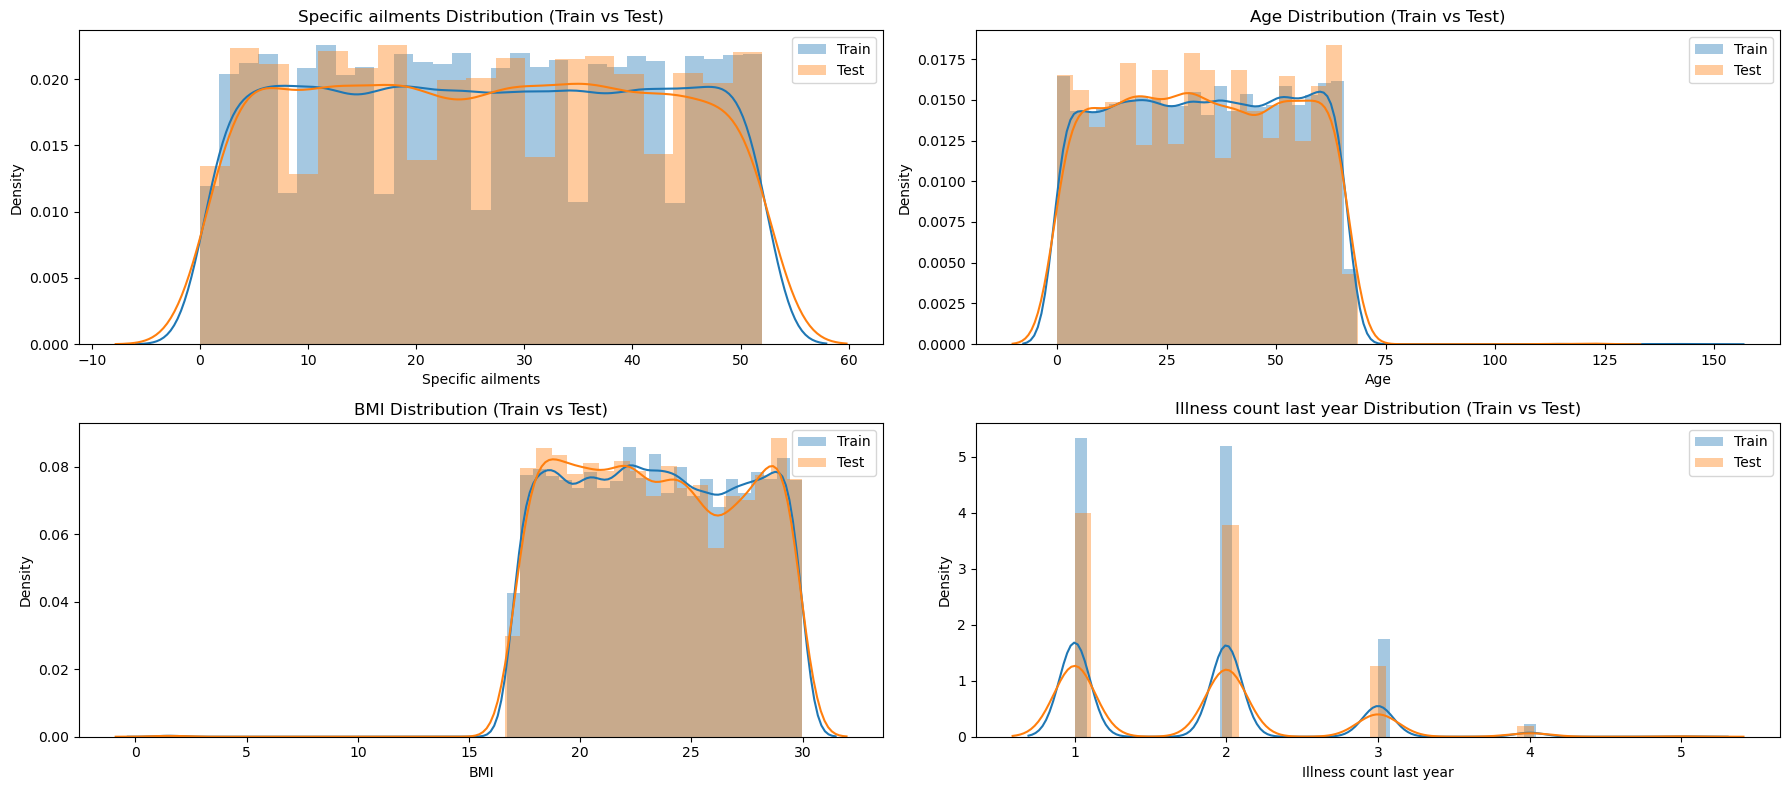

In [18]:
def plot_histograms(df_train, df_test, features, n_cols=3):
    n_rows = (len(features) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, var_name in enumerate(features):
      ax = axes[i]
      sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
      sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')
      ax.set_title(f'{var_name} Distribution (Train vs Test)')
      ax.legend()

    plt.tight_layout()
    plt.show()

plot_histograms(train_df, test_df, num_cols, 2)


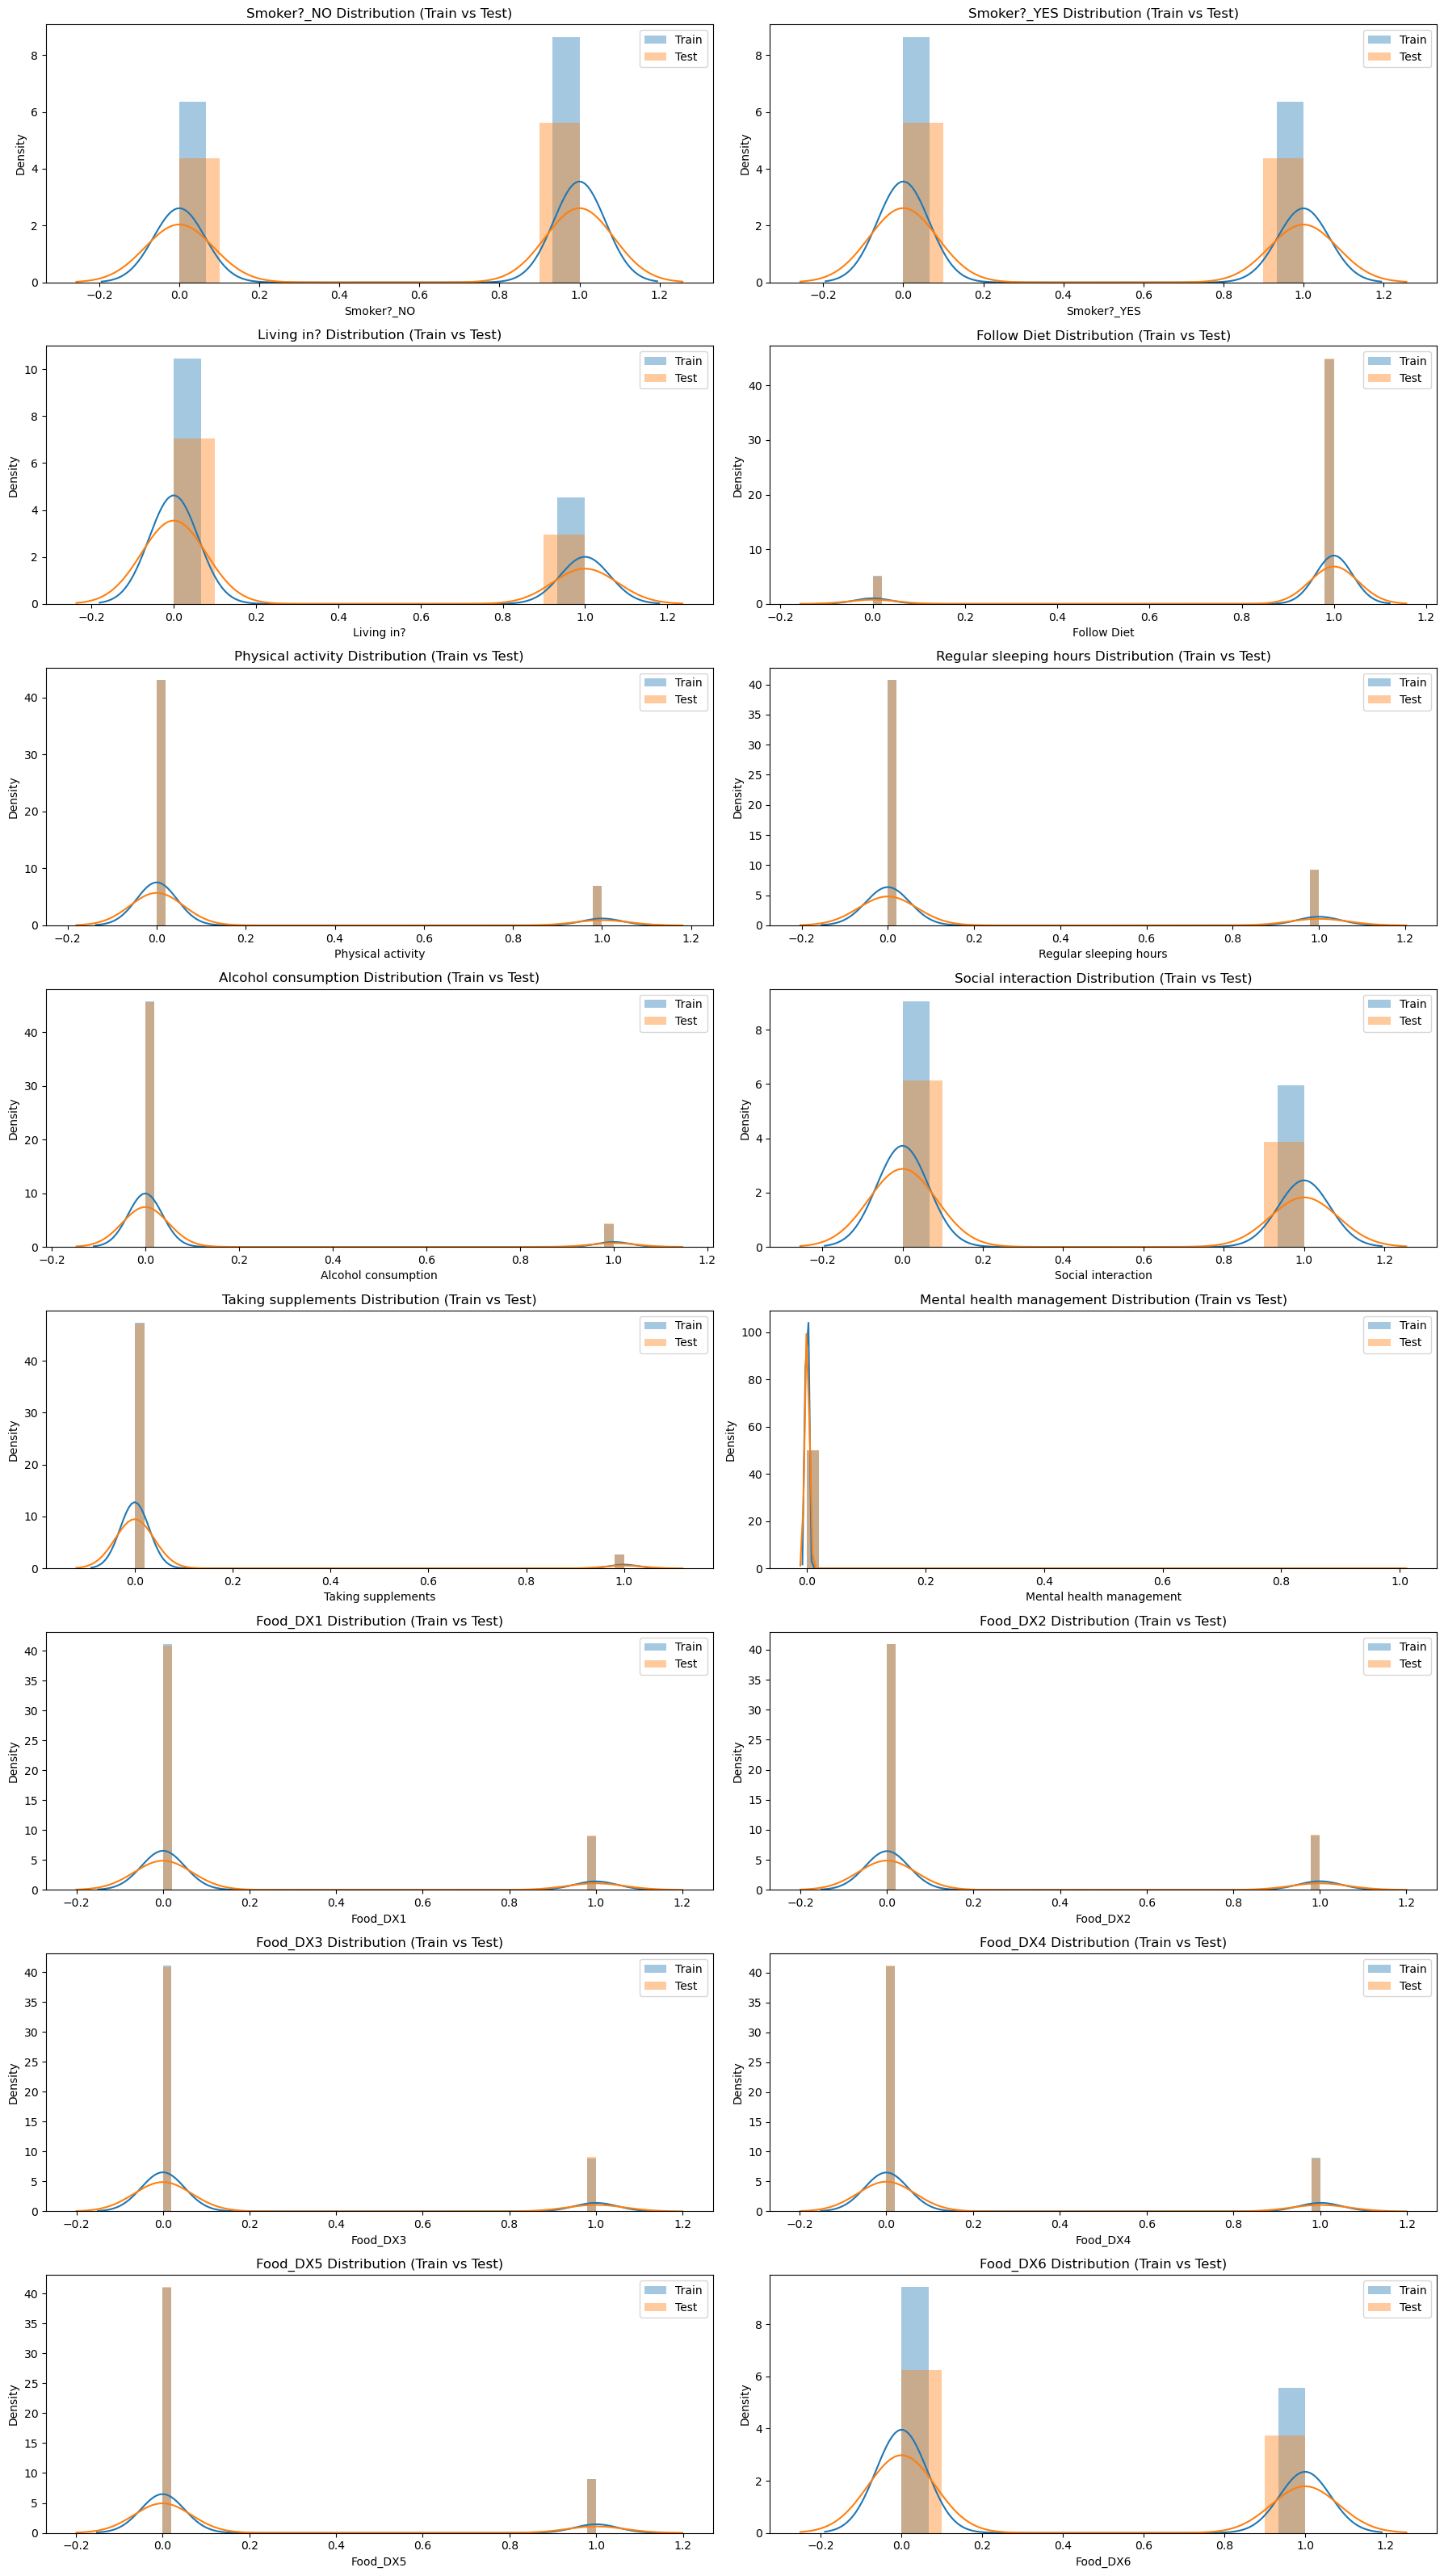

In [19]:
plot_histograms(train_df, test_df, cat_cols, 2)

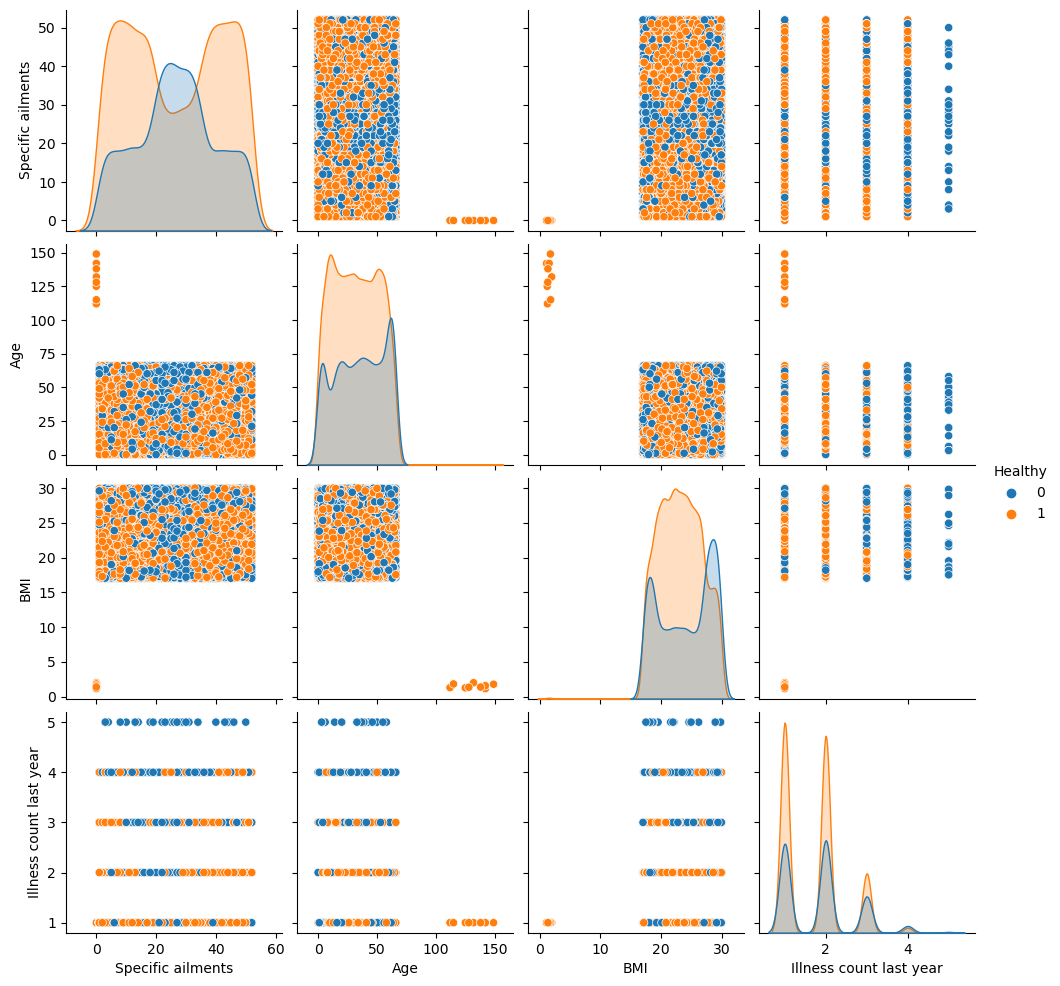

In [20]:
sns.pairplot(data = train_df[num_cols + ['Healthy']], hue='Healthy')

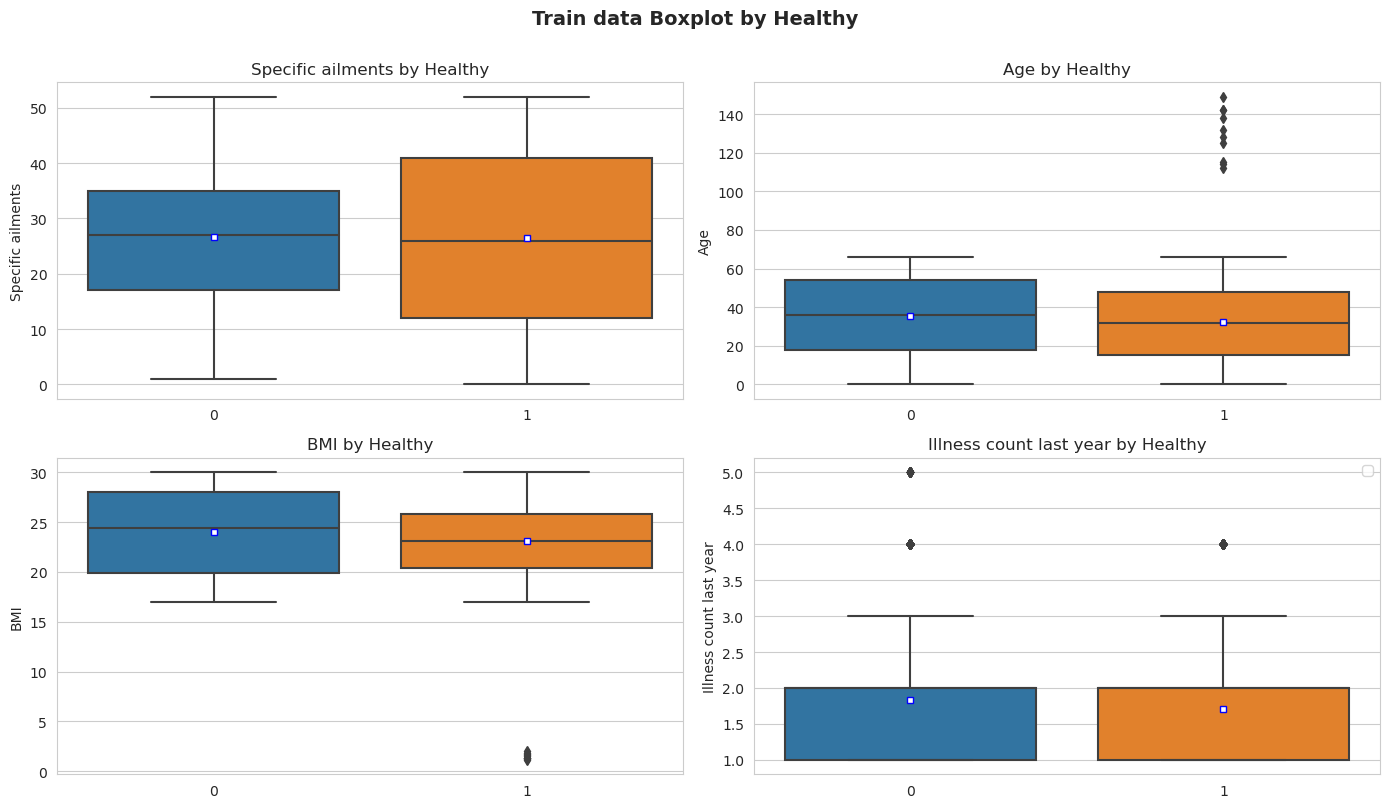

In [21]:
def plot_boxplot(df, hue, n_cols=3, title=''):
    sns.set_style('whitegrid')

    cols = df.columns.drop(hue)
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))

    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.boxplot(data=df, x=hue, y=var_name, ax=ax, showmeans=True,
                    meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":"5"})
        ax.set_title(f'{var_name} by {hue}')
        ax.set_xlabel('')

    fig.suptitle(f'{title} Boxplot by {hue}', fontweight='bold', fontsize=14, y=1.005)
    plt.tight_layout()
    plt.legend()
    plt.show()

plot_boxplot(train_df[num_cols + ['Healthy']], hue='Healthy', n_cols=2, title='Train data')
# plot_boxplot(df_train[num_cols+target_cols], hue=target_cols[1], n_cols=4, title='Train data')

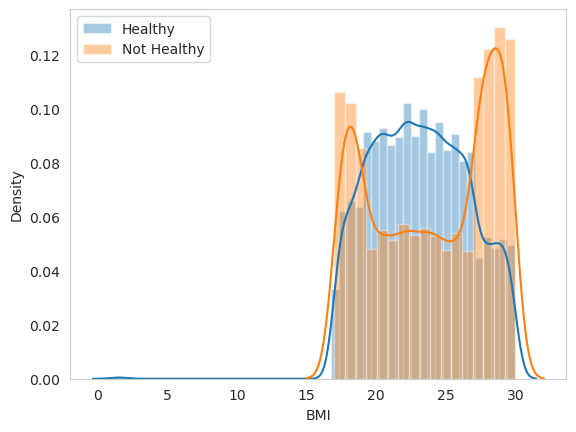

In [22]:
      sns.distplot(train_df[train_df['Healthy']==1]['BMI'], kde=True, label='Healthy')
      sns.distplot(train_df[train_df['Healthy']==0]['BMI'], kde=True, label='Not Healthy')
      plt.legend()
      plt.grid()

In [23]:
train_df['BMI']=np.where(train_df['BMI']<10,train_df['BMI'].median(),train_df['BMI'])
test_df['BMI']=np.where(test_df['BMI']<10,test_df['BMI'].median(),test_df['BMI'])

In [24]:
train_df.isnull().sum()

ID1                           0
Specific ailments             0
ID2                           0
Age                           0
BMI                           0
Living in?                    0
Follow Diet                 973
Physical activity           973
Regular sleeping hours      973
Alcohol consumption         973
Social interaction          973
Taking supplements          973
Mental health management    973
Illness count last year     973
Healthy                       0
Food_DX1                      0
Food_DX2                      0
Food_DX3                      0
Food_DX4                      0
Food_DX5                      0
Food_DX6                      0
Smoker?_NO                    0
Smoker?_YES                   0
dtype: int64

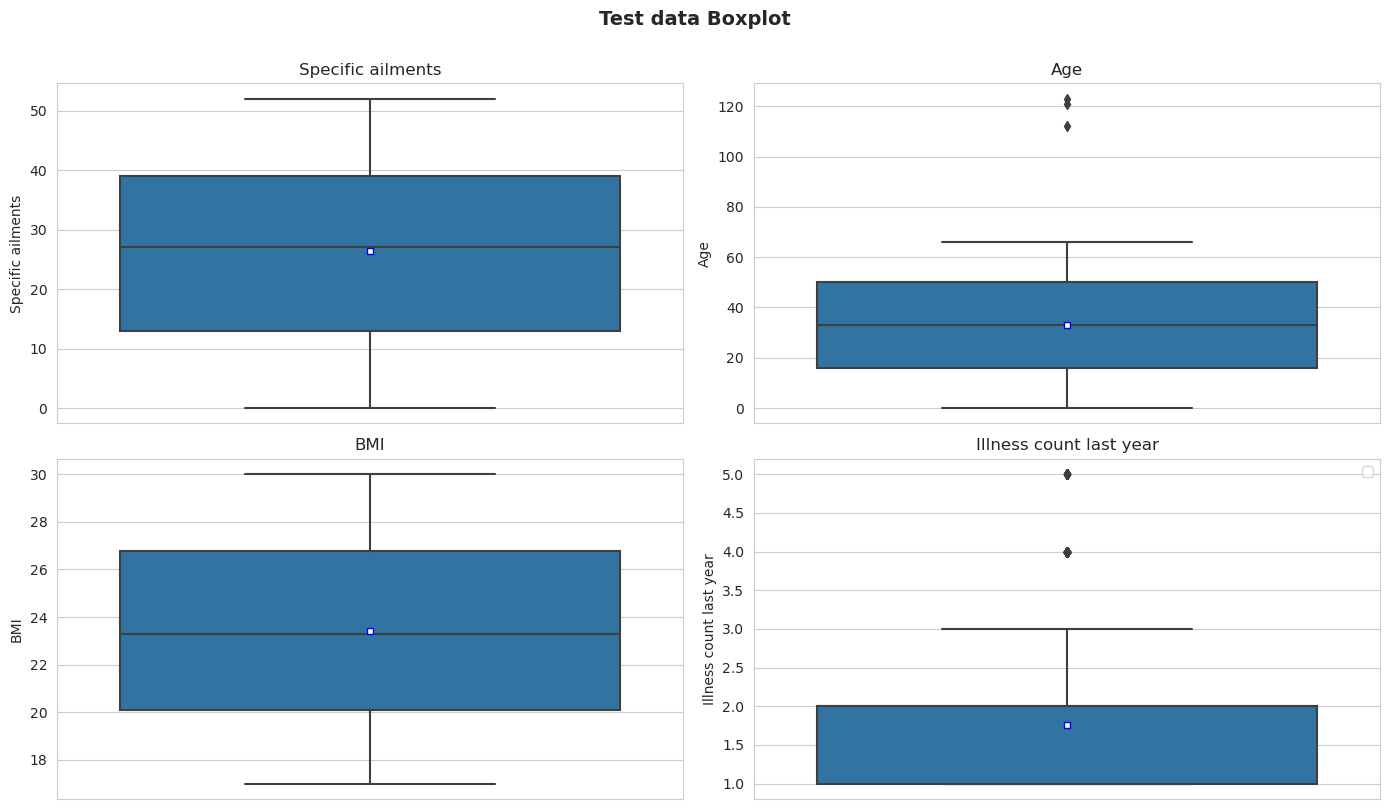

In [25]:
n_rows = 2
n_cols = 2
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))
for i, var_name in enumerate(num_cols):
    row = i // n_cols
    col = i % n_cols

    ax = axes[row, col]
    sns.boxplot(data=test_df, x=None, y=var_name, ax=ax, showmeans=True,
                meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":"5"})
    ax.set_title(f'{var_name}')
    ax.set_xlabel('')

fig.suptitle(f'Test data Boxplot', fontweight='bold', fontsize=14, y=1.005)
plt.tight_layout()
plt.legend()
plt.show()

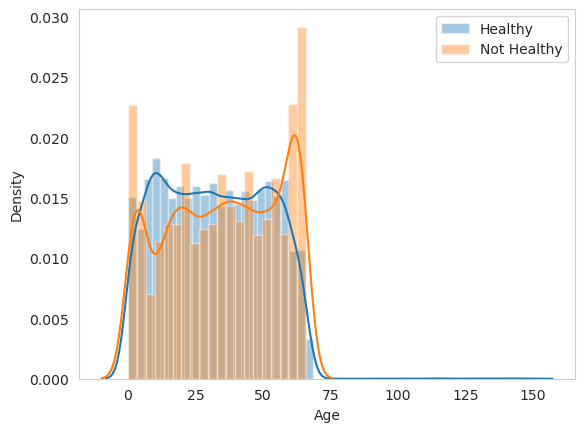

In [26]:
sns.distplot(train_df[train_df['Healthy']==1]['Age'], kde=True, label='Healthy')
sns.distplot(train_df[train_df['Healthy']==0]['Age'], kde=True, label='Not Healthy')
plt.legend()
plt.grid()

In [27]:
train_df['Age']=np.where(train_df['Age']>100,train_df[train_df['Healthy']==1]['Age'].median(),train_df['Age'])
test_df['Age']=np.where(test_df['Age']>100,test_df['Age'].median(),test_df['Age'])

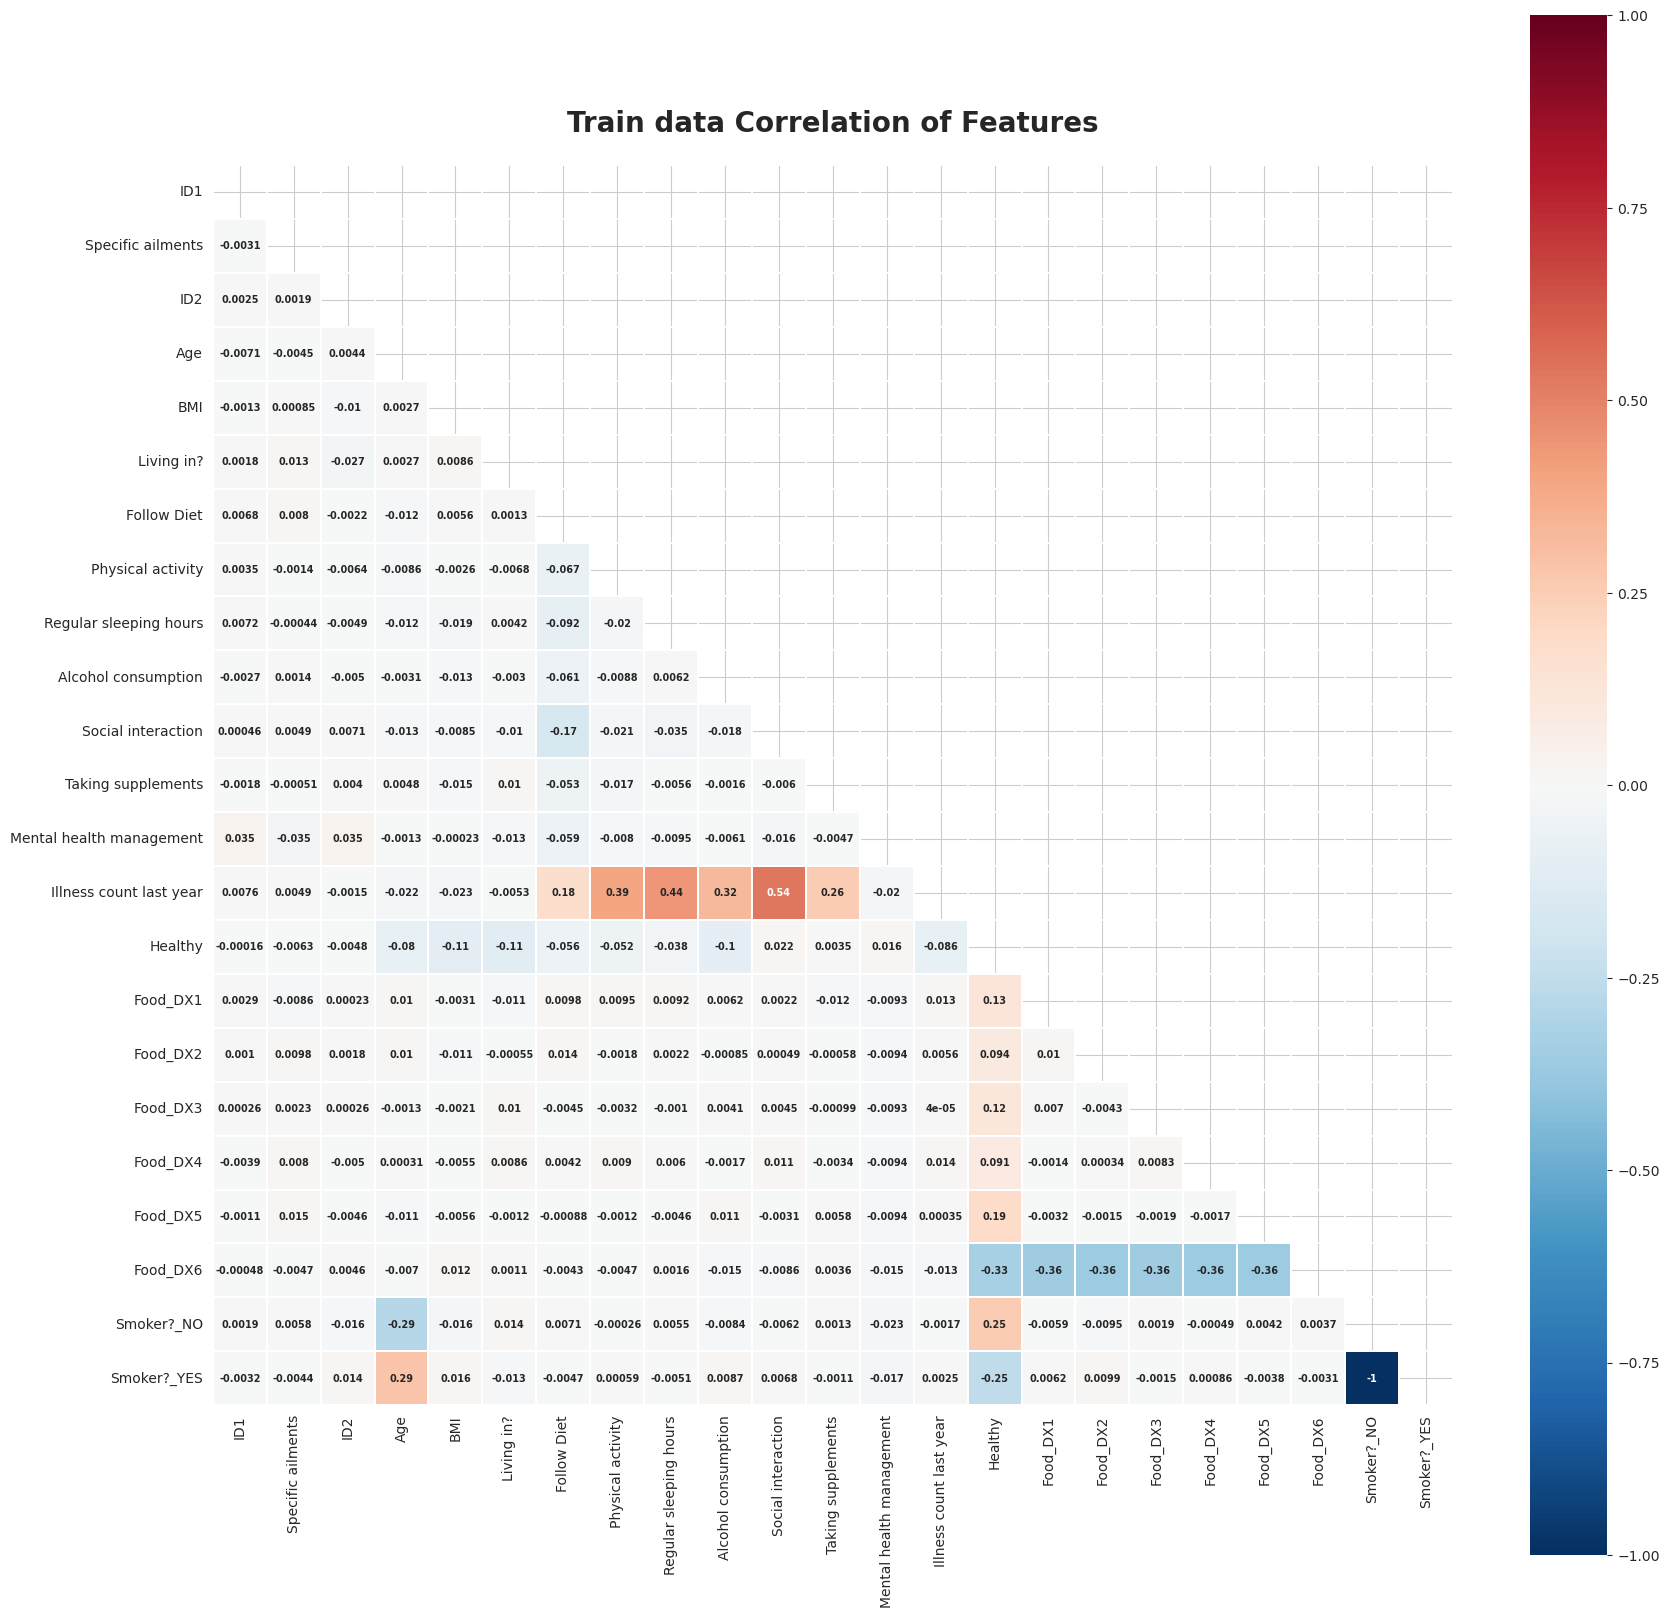

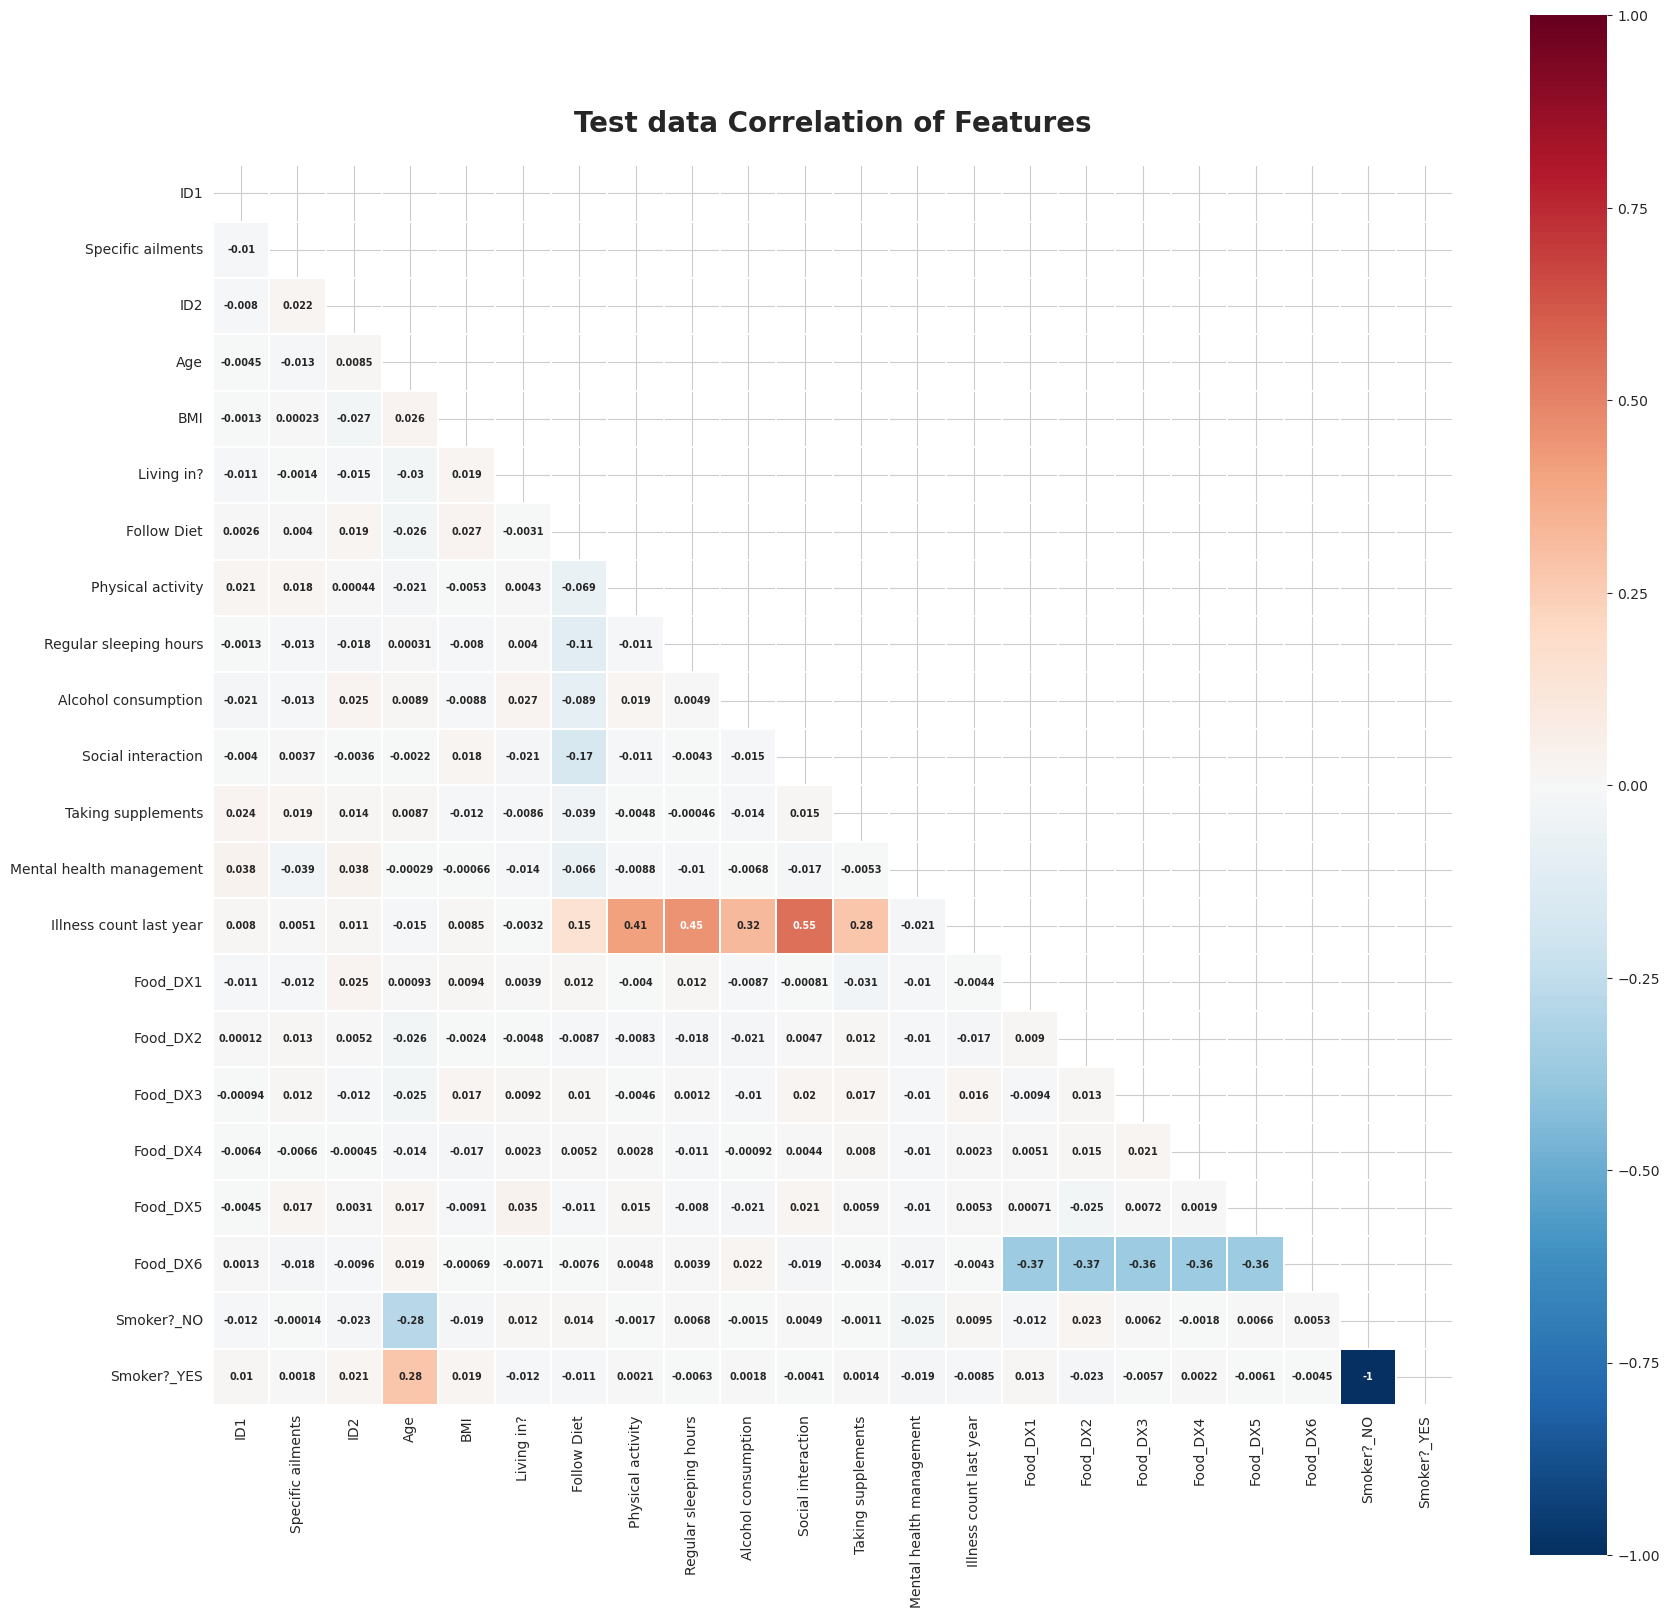

In [28]:
def plot_heatmap(df, title, figsize=(20, 20), fontsize=7):
    # Create a mask for the diagonal elements
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    # Set the colormap and figure size
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=figsize)

    # Set the title and font properties
    plt.title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=20)

    # Plot the heatmap with the masked diagonal elements
    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1.0,
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": fontsize, "weight": "bold"},
                mask=mask)

plot_heatmap(train_df, title='Train data')
plot_heatmap(test_df, title='Test data')

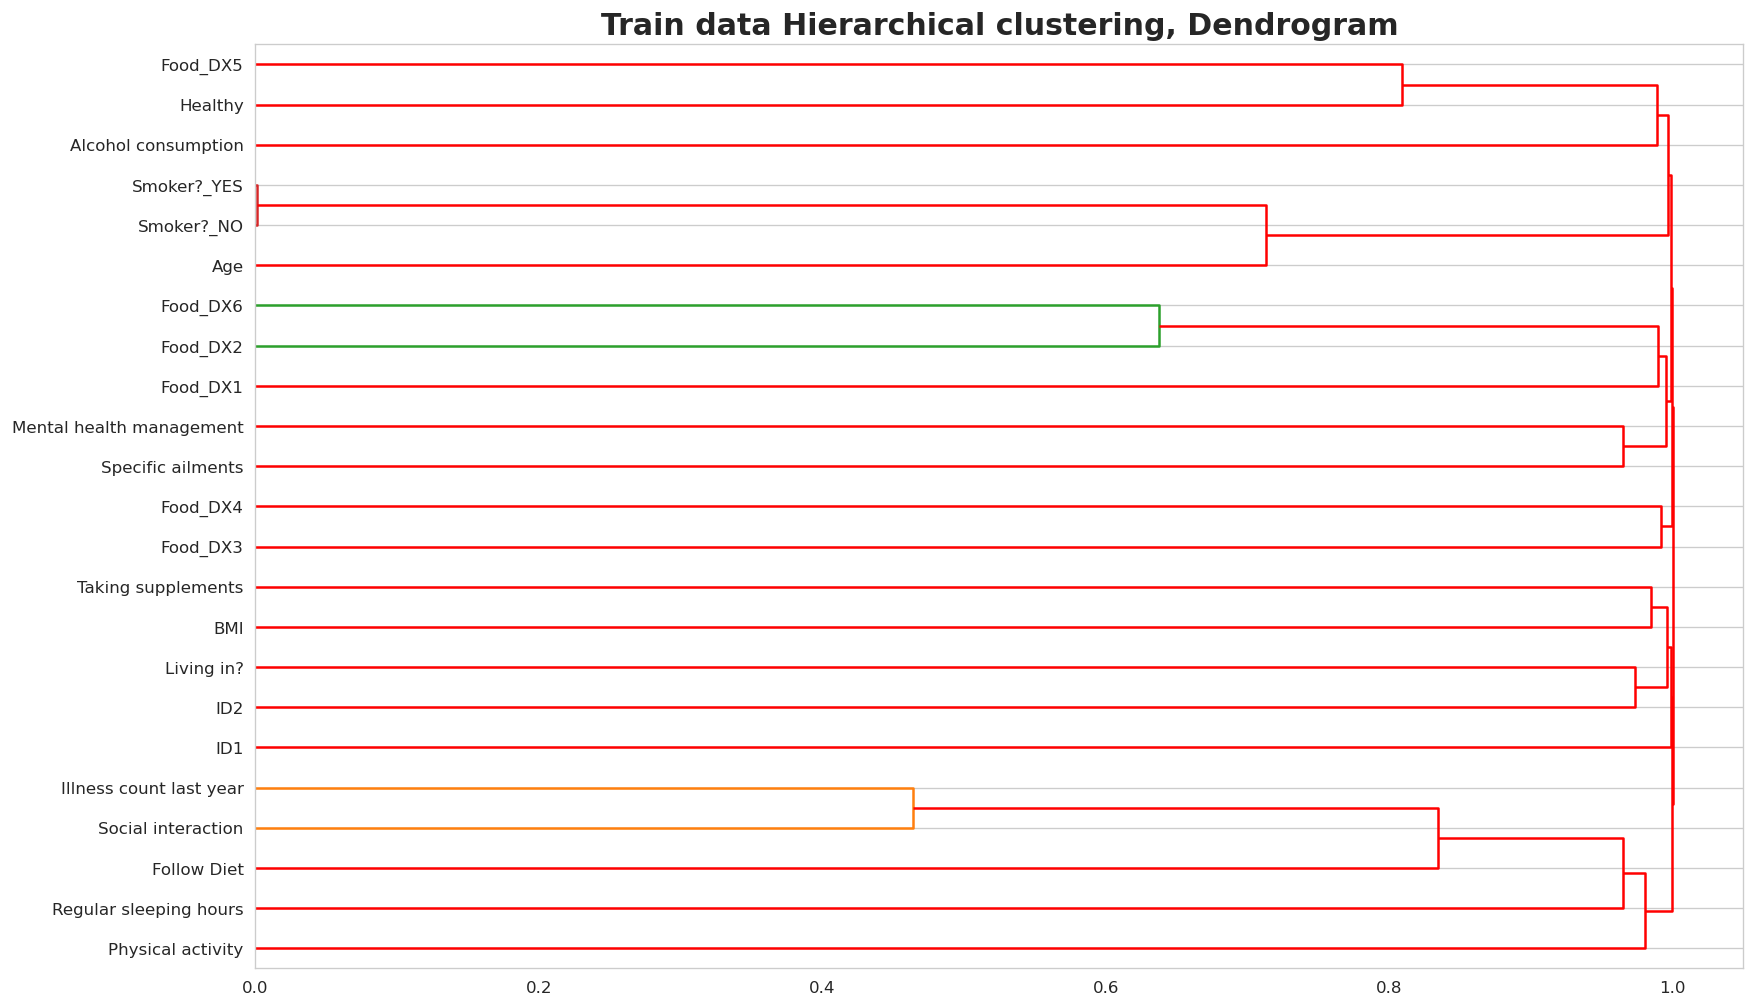

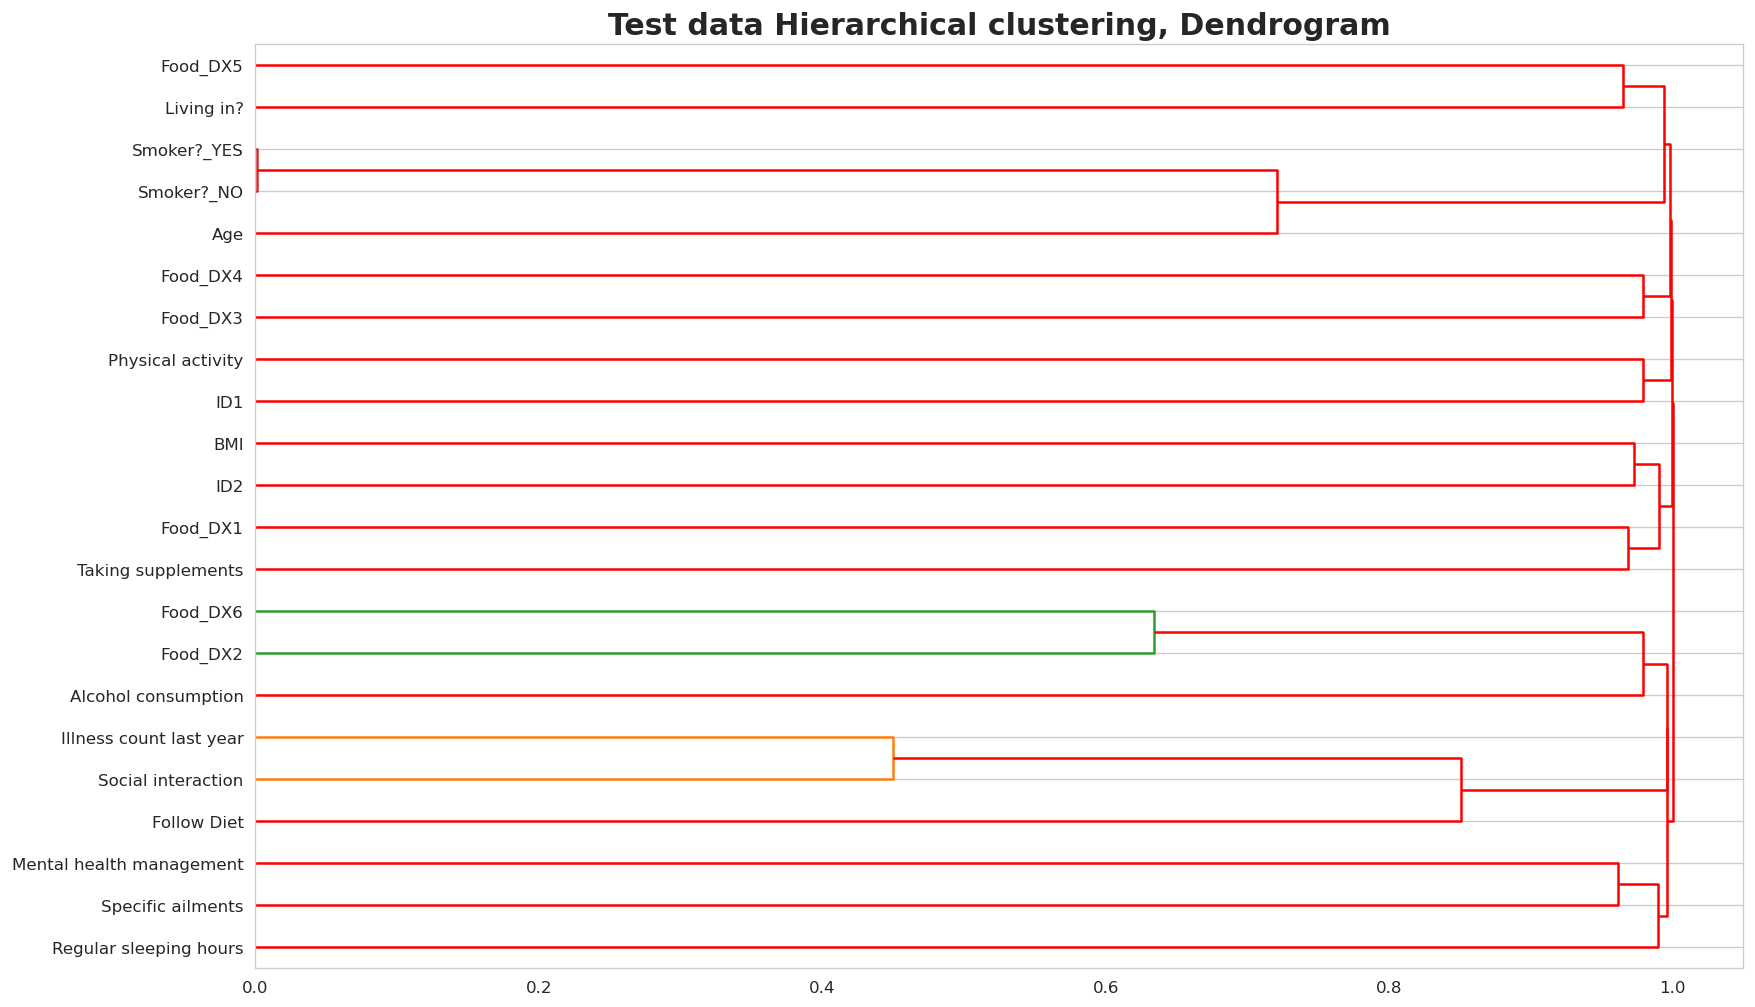

In [29]:
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

def hierarchical_clustering(data, title):
    fig, ax = plt.subplots(1, 1, figsize=(16, 10), dpi=120)
    correlations = data.corr()
    converted_corr = 1 - np.abs(correlations)
    Z = linkage(squareform(converted_corr), 'complete')

    dn = dendrogram(Z, labels=data.columns, ax=ax, above_threshold_color='#ff0000', orientation='right')
    hierarchy.set_link_color_palette(None)
    plt.grid(axis='x')
    plt.title(f'{title} Hierarchical clustering, Dendrogram', fontsize=18, fontweight='bold')
    plt.show()

hierarchical_clustering(train_df, title='Train data')
hierarchical_clustering(test_df, title='Test data')

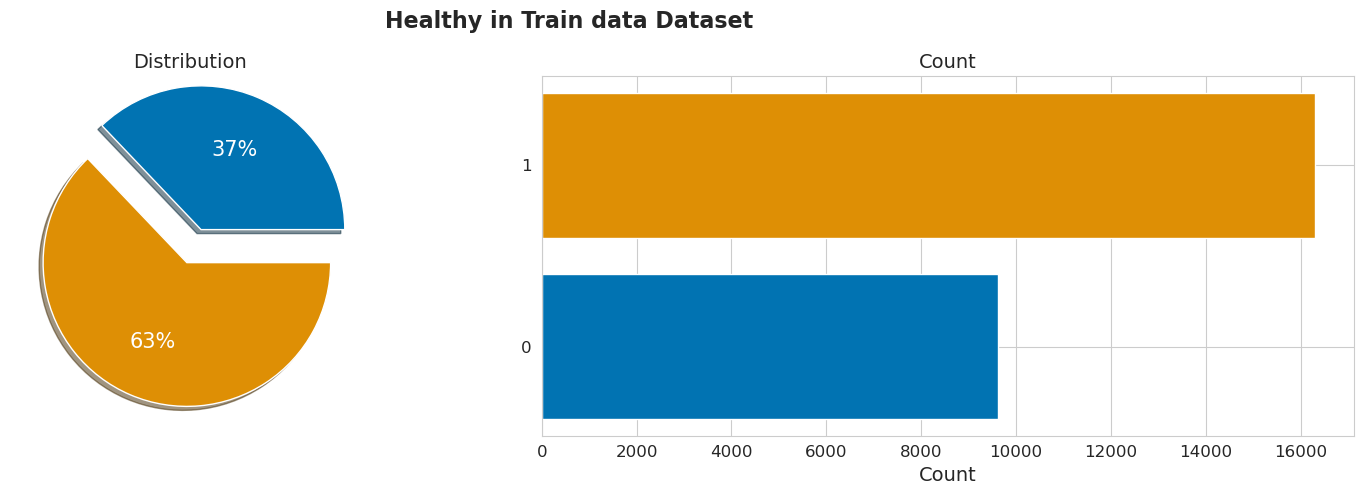

In [30]:
def plot_target_feature(df_train, target_col, figsize=(16,5), palette='colorblind', name='Train'):
    df_train = df_train.fillna('Nan')

    fig, ax = plt.subplots(1, 2, figsize=figsize)
    ax = ax.flatten()

    # Get unique categories and their counts
    unique_categories, category_counts = np.unique(df_train[target_col], return_counts=True)

    # Pie chart
    pie_colors = sns.color_palette(palette, len(unique_categories))
    pie_explode = [0.05] * len(unique_categories)
    min_category_index = np.argmin(category_counts)
    pie_explode[min_category_index] = 0.2

    ax[0].pie(
        category_counts,
        shadow=True,
        explode=pie_explode,
        autopct='%1.f%%',
        textprops={'size': 15, 'color': 'white'},
        colors=pie_colors
    )
    ax[0].set_aspect('equal')
    ax[0].set_title('Distribution', fontsize=14)

    # Bar plot
    bar_colors = sns.color_palette(palette, len(unique_categories))
    bar_indices = np.argsort(category_counts)
    bar_data = category_counts[bar_indices]
    bar_labels = unique_categories[bar_indices]

    ax[1].barh(
        range(len(bar_labels)),  # Use range of indices as y-values
        bar_data,
        color=[bar_colors[i] for i in bar_indices]
    )
    ax[1].set_yticks(range(len(bar_labels)))  # Set y-ticks at the center of each bar
    ax[1].set_yticklabels(bar_labels)  # Set the correct category labels
    ax[1].set_xlabel('Count', fontsize=14)
    ax[1].set_ylabel('')
    ax[1].tick_params(labelsize=12)
    ax[1].yaxis.set_tick_params(width=0)
    ax[1].set_title('Count', fontsize=14)

    fig.suptitle(f'{target_col} in {name} Dataset', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_target_feature(train_df, 'Healthy', figsize=(16,5), palette='colorblind', name='Train data')

In [31]:
missing_feats = ['Follow Diet',
                'Physical activity',
                'Regular sleeping hours',
                'Alcohol consumption',
                'Social interaction',
                'Taking supplements',
                'Mental health management',
                'Illness count last year']

In [32]:
train_df[train_df['Follow Diet'].isna()]

,ID1,Specific ailments,ID2,Age,BMI,Living in?,Follow Diet,Physical activity,Regular sleeping hours,Alcohol consumption,...,Illness count last year,Healthy,Food_DX1,Food_DX2,Food_DX3,Food_DX4,Food_DX5,Food_DX6,Smoker?_NO,Smoker?_YES
39,15386,36,7184,47.0,27.557885,0,NaN,NaN,NaN,NaN,...,NaN,0,0,0,0,0,0,1,0,1
41,18798,13,2626,44.0,28.514937,0,NaN,NaN,NaN,NaN,...,NaN,1,0,0,0,0,1,0,1,0
63,18577,51,12228,65.0,23.120156,0,NaN,NaN,NaN,NaN,...,NaN,0,0,0,0,0,0,1,0,1
82,31496,32,3702,34.0,26.531821,1,NaN,NaN,NaN,NaN,...,NaN,0,0,0,1,0,0,0,0,1
90,15245,30,2110,32.0,19.701808,0,NaN,NaN,NaN,NaN,...,NaN,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25847,25685,46,265,31.0,26.507633,0,NaN,NaN,NaN,NaN,...,NaN,1,0,1,0,1,0,0,0,1
25872,26523,39,3727,18.0,22.856948,0,NaN,NaN,NaN,NaN,...,NaN,1,0,0,0,0,0,1,1,0
25892,24884,14,6071,60.0,23.967078,0,NaN,NaN,NaN,NaN,...,NaN,1,1,0,1,0,0,0,1,0
25893,9926,16,1064,52.0,21.774523,0,NaN,NaN,NaN,NaN,...,NaN,1,1,0,0,1,0,0,1,0


In [33]:
import miceforest as mf
kernel = mf.ImputationKernel(
  data=train_df,
  save_all_iterations=True,
  random_state=1343
)
# Run the MICE algorithm for 3 iterations on each of the datasets
kernel.mice(iterations=2,n_estimators=500,verbose=True)
#print(kernel)
imputed_train_df = kernel.complete_data(dataset=0, inplace=False)

Initialized logger with name mice 1-2
Dataset 0
1  | Social interaction | Regular sleeping hours | Mental health management | Illness count last year | Physical activity | Follow Diet | Alcohol consumption | Taking supplements
2  | Social interaction | Regular sleeping hours | Mental health management | Illness count last year | Physical activity | Follow Diet | Alcohol consumption | Taking supplements


In [34]:
kernel = mf.ImputationKernel(
  data=test_df,
  save_all_iterations=True,
  random_state=1343
)
# Run the MICE algorithm for 3 iterations on each of the datasets
kernel.mice(iterations=2,n_estimators=500,verbose=True)
#print(kernel)
imputed_test_df = kernel.complete_data(dataset=0, inplace=False)

Initialized logger with name mice 1-2
Dataset 0
1  | Alcohol consumption | Physical activity | Taking supplements | Mental health management | Illness count last year | Follow Diet | Regular sleeping hours | Social interaction
2  | Alcohol consumption | Physical activity | Taking supplements | Mental health management | Illness count last year | Follow Diet | Regular sleeping hours | Social interaction


In [ ]:
params = {'learning_rate': 0.3,
              'application': 'binary',
              'num_leaves': 31,
              'verbosity': -1,
              'metric': 'f1',
              'data_random_seed': 2,
              'bagging_fraction': 0.8,
              'feature_fraction': 0.6,
              'nthread': 4,
              'lambda_l1': 1,
              'lambda_l2': 1}
# train_data = lgb.Dataset(X_train, label=y_train)
# val_data = lgb.Dataset(X_test, label=y_test)
# watchlist = [train_data, val_data]

# model_lgb = lgb.train(params, train_set=train_data, valid_sets=watchlist)

from sklearn.model_selection import KFold, StratifiedKFold
N_FOLDS = 10
X = imputed_train_df[num_cols+cat_cols]
y = imputed_train_df['Healthy']
folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
oof = np.zeros(len(train_df))
sub = np.zeros(len(test_df))
scores = [0 for _ in range(folds.n_splits)]
for fold_, (train_idx, val_idx) in enumerate(folds.split(X.values, y)):
    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_val, y_val = X.loc[val_idx], y.loc[val_idx]
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    watchlist = [train_data, val_data]
    clf = lgb.train(params, train_set = train_data, valid_sets=watchlist)
    oof[val_idx] = clf.predict(X_val)
    sub += clf.predict(test_df[num_cols+cat_cols])/folds.n_splits
    scores[fold_] = roc_auc_score(y[val_idx], oof[val_idx])
    print("Fold {}: {}".format(fold_+1, round(scores[fold_],5)))

print("CV score(auc): {:<8.5f}, (std: {:<8.5f})".format(roc_auc_score(y, oof), np.std(scores)))

In [37]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(sampling_strategy='minority', random_state=43, k_neighbors=30, n_jobs=-1)
# X, y = SMOTE().fit_resample(imputed_train_df[num_cols+cat_cols], imputed_train_df['Healthy'])
# X.shape, y.shape

from imblearn.combine import SMOTEENN
smt = SMOTEENN(random_state=42)
X, y = smt.fit_resample(imputed_train_df[num_cols+cat_cols], imputed_train_df['Healthy'])
X.shape, y.shape

((17413, 20), (17413,))

In [42]:
from sklearn.metrics import roc_auc_score, f1_score
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(imputed_train_df[num_cols + cat_cols], imputed_train_df.Healthy, test_size=0.2)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective": "binary",
        'device': 'gpu',
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        'learning_rate':trial.suggest_float("learning_rate", 1e-8, 0.5, log=True),
        "n_estimators" : trial.suggest_int('n_estimators', 100, 1600,10),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    score = f1_score(valid_y, pred_labels)
    return score



study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=400)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
lgbm1_params = study.best_params
lgbm1_params

[I 2023-07-16 16:50:49,898] A new study created in memory with name: no-name-18fdb8dd-17df-4d4c-874c-0d4ad7685c10
[I 2023-07-16 16:50:52,717] Trial 0 finished with value: 0.7806656474185582 and parameters: {'learning_rate': 0.0003335566734830697, 'n_estimators': 250, 'lambda_l1': 0.03443432886747309, 'lambda_l2': 1.0137559631924762e-07, 'num_leaves': 71, 'feature_fraction': 0.6120226976290368, 'bagging_fraction': 0.40782882459880393, 'bagging_freq': 6, 'min_child_samples': 72}. Best is trial 0 with value: 0.7806656474185582.
[I 2023-07-16 16:51:20,316] Trial 1 finished with value: 0.8058386812633698 and parameters: {'learning_rate': 0.0004892970023522574, 'n_estimators': 1270, 'lambda_l1': 0.000401400180875216, 'lambda_l2': 0.0002072660628733625, 'num_leaves': 193, 'feature_fraction': 0.40532158225528825, 'bagging_fraction': 0.8882835344194412, 'bagging_freq': 5, 'min_child_samples': 58}. Best is trial 1 with value: 0.8058386812633698.
[I 2023-07-16 16:51:37,768] Trial 2 finished with 

Number of finished trials: 400
Best trial:
  Value: 0.8857398568019094
  Params: 
    learning_rate: 0.17650910666382855
    n_estimators: 320
    lambda_l1: 0.8971108823988938
    lambda_l2: 1.1707942115208905e-06
    num_leaves: 4
    feature_fraction: 0.7897397976035941
    bagging_fraction: 0.9560591585865253
    bagging_freq: 5
    min_child_samples: 80


NameError: name 'lbgm1_params' is not defined

In [43]:
lgbm1_params

{'learning_rate': 0.17650910666382855,
 'n_estimators': 320,
 'lambda_l1': 0.8971108823988938,
 'lambda_l2': 1.1707942115208905e-06,
 'num_leaves': 4,
 'feature_fraction': 0.7897397976035941,
 'bagging_fraction': 0.9560591585865253,
 'bagging_freq': 5,
 'min_child_samples': 80}

In [53]:
# lgbm1_params = {'learning_rate': 0.07119338105902856,
#                 'n_estimators': 500,
#                 'lambda_l1': 0.003864377521482835,
#                 'lambda_l2': 0.00022232567432870764,
#                 'num_leaves': 121,
#                 'feature_fraction': 0.5489823605843281,
#                 'bagging_fraction': 0.5167816572185776,
#                 'bagging_freq': 3,
#                 'min_child_samples': 26}
lgbm = lgb.LGBMClassifier(**lgbm1_params)
lgbm.fit(X, y)
pred = lgbm.predict(imputed_test_df[num_cols + cat_cols])

[LightGBM] [Warning] lambda_l1 is set=0.0019741859892959948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019741859892959948
[LightGBM] [Warning] feature_fraction is set=0.5684312360447108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5684312360447108
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0007004452243417878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007004452243417878
[LightGBM] [Warning] bagging_fraction is set=0.7893956587283357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7893956587283357


In [54]:
submission = pd.DataFrame({'predictions': pred})
submission.to_csv('/kaggle/working/submission_anindya.csv', index = False)

In [ ]:
from xgboost import cv
def objective(trial):
    # data_dmatrix = xgb.DMatrix(data=imputed_train_df[num_cols + cat_cols].to_numpy(),label=imputed_train_df.Healthy.to_numpy())
    data_dmatrix = xgb.DMatrix(data=imputed_train_df[num_cols + cat_cols + ['ID2']].to_numpy(),
                               label=imputed_train_df.Healthy.to_numpy())
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # No. of trees
        "n_estimators": trial.suggest_int('n_estimators', 200, 2000, 20),
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        'tree_method' : 'gpu_hist',
        'predictor' : 'gpu_predictor'
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

#     bst = xgb.train(param, dtrain)
#     preds = bst.predict(dvalid)
#     pred_labels = np.rint(preds)
    score  = cv(dtrain=data_dmatrix, params=param, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)['test-auc-mean'].mean()
    return score



study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=400, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
xgb1_params = study.best_params
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [35]:
xgb1_params

{'n_estimators': 900,
 'booster': 'dart',
 'lambda': 0.0004114059240550772,
 'alpha': 1.1001599740053938e-07,
 'subsample': 0.5378592475635453,
 'colsample_bytree': 0.9792086350898069,
 'max_depth': 7,
 'min_child_weight': 6,
 'eta': 0.18936283489984523,
 'gamma': 3.1594399085305505e-08,
 'grow_policy': 'depthwise',
 'sample_type': 'weighted',
 'normalize_type': 'tree',
 'rate_drop': 0.00023139976570891636,
 'skip_drop': 1.454945958262775e-06}

In [41]:
import pprint
def rfe_cv(estimator,step,cv,scoring,X_train,y_train):
    # Instantiate Recursive Feature Elimination object
    selector = RFECV(estimator=estimator, step=step, cv=cv, scoring=scoring)
    # Fit to training data.
    selector.fit(X_train,y_train)
    # Print and return selected and removed columns. 
    selected_columns = X_train.columns[selector.support_]
    removed_columns = X_train.columns[~selector.support_]
    print('*'*20+'SELECTED'+'*'*19)
    pprint.pprint(list(selected_columns))
    print('\n'+'*'*20+'REMOVED'+'*'*20)
    pprint.pprint(list(removed_columns))
    return selected_columns

lgbm = lgb.LGBMClassifier(**lgbm1_params, device = 'gpu', verbose = 0)
lgb_selector = rfe_cv(lgbm,1,10,'f1', imputed_train_df[num_cols + cat_cols + ['ID2']], imputed_train_df.Healthy)
lgb_selector

[LightGBM] [Warning] lambda_l1 is set=0.0019741859892959948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019741859892959948
[LightGBM] [Warning] feature_fraction is set=0.5684312360447108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5684312360447108
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0007004452243417878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007004452243417878
[LightGBM] [Warning] bagging_fraction is set=0.7893956587283357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7893956587283357
[LightGBM] [Warning] lambda_l1 is set=0.0019741859892959948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019741859892959948
[LightGBM] [Warning] feature_fraction is set=0.5684312360447108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5684312360447108
[LightGBM] [Warning

Index(['Specific ailments', 'Age', 'BMI', 'Illness count last year',
       'Smoker?_NO', 'Smoker?_YES', 'Living in?', 'Follow Diet',
       'Physical activity', 'Regular sleeping hours', 'Alcohol consumption',
       'Social interaction', 'Taking supplements', 'Food_DX1', 'Food_DX2',
       'Food_DX3', 'Food_DX4', 'Food_DX5', 'Food_DX6'],
      dtype='object')

In [ ]:
def objective(trial, X, y, cv, scoring):
  """
  An objective function to tune hyperparameters of Gradient Boosting Classifier.
  Args:
    trial: an Optuna trial
    X: DataFrame object, features
    y: Series object, Labels
    cv: k folds to cross-validate
    scoring: String, evaluation metric
  Return:
    Mean test accuracy
  """

  params = {
    "n_estimators": trial.suggest_int("n_estimators", 100, 5000, step = 100),
    "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log = True),
    "max_depth": trial.suggest_int("max_depth", 3, 9),
    "subsample": trial.suggest_float("subsample", 0.5, 0.9, step = 0.1),
    "max_features": trial.suggest_categorical("max_features", [1.0, "sqrt", "log2"]),
    "random_state": 42,
    }
  # Perform cross validation
  gb_class = GradientBoostingClassifier(**params)

  # Compute scores
  scores = cross_validate(gb_class, X, y, cv = cv, scoring = scoring, n_jobs = -1)
  accuracy = scores["test_score"].mean()

  return accuracy


study = optuna.create_study(direction = "maximize")

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

func = lambda trial: objective(trial, X.to_numpy(), y.to_numpy(), cv = kf, scoring = "f1")

study.optimize(func, n_trials = 100)

study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
gb1_params = study.best_params

In [ ]:

from optuna.samplers import TPESampler

def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        task_type="GPU",
        verbose=False
    )
    X_train, X_test, y_train, y_test = train_test_split(imputed_train_df[num_cols + cat_cols], 
                                                        imputed_train_df.Healthy, 
                                                        test_size=0.2, random_state=4)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=400)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
xgb1_params = study.best_params
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

cat1_params = study.best_params
cat1_params

In [33]:
class Classifier:
  def __init__(self , random_state=0):
      self.random_state = random_state
      self.models = self._define_model()
      
  def _define_model(self):
      
        xgb1_params = {
            'n_estimators': 1420,
            'booster': 'gblinear',
            'lambda': 2.0090401760222465e-08,
            'alpha': 3.888579528339441e-05,
            'subsample': 0.8196849038090053,
            'colsample_bytree': 0.5375495856693846,
            'eval_metric': 'auc',
            'verbosity': 0,
            'random_state': self.random_state,
        }
        xgb2_params = {
            'learning_rate': 0.1,
            'max_depth': 5,
            'n_estimators': 200,
            'verbosity': 0,
            'random_state': self.random_state,
        }
    
        lgb1_params = {
            'learning_rate': 0.014503930360621975,
            'n_estimators': 1410,
            'lambda_l1': 0.0019741859892959948,
            'lambda_l2': 0.0007004452243417878,
            'num_leaves': 25,
            'feature_fraction': 0.5684312360447108,
            'bagging_fraction': 0.7893956587283357,
            'bagging_freq': 5,
            'min_child_samples': 79,
            'verbose': -1,
            'metric': 'f1',
            'random_state': self.random_state
        }
        
        rfc1_params = {
            'max_depth': 16, 
            'min_samples_leaf': 10,
            'n_estimators': 1090
        }

        gb1_params = {
            'n_estimators': 2200, 
            'learning_rate': 0.009618759395796055, 
            'max_depth': 5, 'subsample': 0.7, 
            'max_features': 'sqrt'
                    }

        gb2_params = {
            'learning_rate': 0.1,
            'max_depth': 4,
            'n_estimators': 300,
        }
    
        cat1_params = {
            'iterations': 398,
            'learning_rate': 0.05668724559418555,
            'depth': 5,
            'l2_leaf_reg': 8.298192054142277e-08,
            'bootstrap_type': 'Bayesian',
            'random_strength': 2.4207427479005393e-07,
            'bagging_temperature': 0.6005205841657858,
            'od_type': 'Iter',
            'od_wait': 31,
            'verbose': 0,
            'random_state': self.random_state
        }
                
        models = VotingClassifier([
            ("xgb", xgb.XGBClassifier(**xgb1_params)),
            ("lgb", lgb.LGBMClassifier(**lgb1_params)),
            ("cat", CatBoostClassifier(**cat1_params)),
            ("xgb2", xgb.XGBClassifier(**xgb2_params)),
            ('rfc', RandomForestClassifier(**rfc1_params, random_state=self.random_state)),
            ('gbc1', GradientBoostingClassifier(**gb1_params, random_state=self.random_state)),
            ('gbc2', GradientBoostingClassifier(**gb2_params, random_state=self.random_state))
            ], voting='soft')      
        return models


In [5]:
imputed_train_df = pd.read_csv('/kaggle/input/sa-hackathon/imputed_train_df.csv')

In [6]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score

def build_and_evaluate_model(data, target_label):

    # Build the model using the provided model_builder_func
    classifier = Classifier(random_state=0)
    model = classifier.models

#     # Perform cross-validation
#     cv_scores = cross_val_score(model, data, target_label, cv=5, scoring='f1')

#     # Print average ROC-AUC score
#     avg_score = np.mean(cv_scores)
#     print(f"Average F1 Score :  {avg_score}")

    # Make cross-validated predictions
    y_pred = cross_val_predict(model, data, target_label, cv=5)
    y_pred_proba = cross_val_predict(model, data, target_label, cv=5, method='predict_proba')[:, 1]

    # Calculate metrics
    confusion = confusion_matrix(target_label, y_pred)
    report = classification_report(target_label, y_pred)
    roc_auc = roc_auc_score(target_label, y_pred)
    f1 = f1_score(target_label, y_pred)

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(target_label, y_pred_proba)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

    # Print metrics
    print('Confusion Matrix:\n', confusion)
    print('\nClassification Report:\n', report)
    print('\nROC-AUC: ', roc_auc)
    print('\nF1 score: ', f1)
    
# build_and_evaluate_model(imputed_train_df[num_cols + cat_cols], imputed_train_df.Healthy)

[LightGBM] [Warning] lambda_l1 is set=0.0019741859892959948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019741859892959948
[LightGBM] [Warning] bagging_fraction is set=0.7893956587283357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7893956587283357
[LightGBM] [Warning] feature_fraction is set=0.5684312360447108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5684312360447108
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0007004452243417878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007004452243417878
[LightGBM] [Warning] lambda_l1 is set=0.0019741859892959948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019741859892959948
[LightGBM] [Warning] bagging_fraction is set=0.7893956587283357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7893956587283357
[LightGBM] [Warning] featu

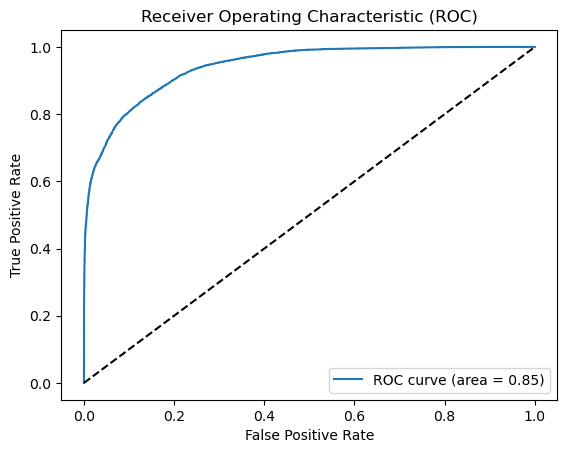

Confusion Matrix:
 [[13840  2460]
 [ 2281 14019]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85     16300
           1       0.85      0.86      0.86     16300

    accuracy                           0.85     32600
   macro avg       0.85      0.85      0.85     32600
weighted avg       0.85      0.85      0.85     32600


ROC-AUC:  0.8545705521472393

F1 score:  0.855364715214009


In [36]:
build_and_evaluate_model(X,y)

In [10]:
class Classifier:
  def __init__(self , random_state=0):
      self.random_state = random_state
      self.models = self._define_model()

  def _define_model(self):

        xgb1_params = {
            'n_estimators': 900,
             'booster': 'dart',
             'lambda': 0.0004114059240550772,
             'alpha': 1.1001599740053938e-07,
             'subsample': 0.5378592475635453,
             'colsample_bytree': 0.9792086350898069,
             'max_depth': 7,
             'min_child_weight': 6,
             'eta': 0.18936283489984523,
             'gamma': 3.1594399085305505e-08,
             'grow_policy': 'depthwise',
             'sample_type': 'weighted',
             'normalize_type': 'tree',
             'rate_drop': 0.00023139976570891636,
             'skip_drop': 1.454945958262775e-06,
            'eval_metric': 'auc',
            'verbosity': 0,
            'random_state': self.random_state,
            'tree_method' : 'gpu_hist',
            'predictor' : 'gpu_predictor'
        }
        xgb2_params = {
            'learning_rate': 0.1,
            'max_depth': 5,
            'n_estimators': 200,
            'verbosity': 0,
            'random_state': self.random_state,
            'tree_method' : 'gpu_hist',
            'predictor' : 'gpu_predictor'
        }

        lgb1_params = {
            'learning_rate': 0.17650910666382855,
             'n_estimators': 320,
             'lambda_l1': 0.8971108823988938,
             'lambda_l2': 1.1707942115208905e-06,
             'num_leaves': 4,
             'feature_fraction': 0.7897397976035941,
             'bagging_fraction': 0.9560591585865253,
             'bagging_freq': 5,
             'min_child_samples': 80,
            'verbose': -1,
            'metric': 'f1',
            'device':'gpu',
            'random_state': self.random_state
        }

        rfc1_params = {
            'max_depth': 16,
            'min_samples_leaf': 10,
            'n_estimators': 1090
        }

        gb1_params = {
            'n_estimators': 2200,
            'learning_rate': 0.009618759395796055,
            'max_depth': 5, 'subsample': 0.7,
            'max_features': 'sqrt'
                    }

        gb2_params = {
            'learning_rate': 0.1,
            'max_depth': 4,
            'n_estimators': 300,
        }

        cat1_params = {
            'iterations': 398,
            'learning_rate': 0.05668724559418555,
            'depth': 5,
            'l2_leaf_reg': 8.298192054142277e-08,
            'bootstrap_type': 'Bayesian',
            'random_strength': 2.4207427479005393e-07,
            'bagging_temperature': 0.6005205841657858,
            'od_type': 'Iter',
            'od_wait': 31,
            'verbose': 0,
            #'task_type': "GPU",
            'random_state': self.random_state
        }

        models = VotingClassifier([
            ("xgb", xgb.XGBClassifier(**xgb1_params)),
            ("lgb", lgb.LGBMClassifier(**lgb1_params)),
            ("cat", CatBoostClassifier(**cat1_params)),
            ("xgb2", xgb.XGBClassifier(**xgb2_params)),
            ('rfc', RandomForestClassifier(**rfc1_params, random_state=self.random_state)),
            ('gbc1', GradientBoostingClassifier(**gb1_params, random_state=self.random_state)),
            ('gbc2', GradientBoostingClassifier(**gb2_params, random_state=self.random_state))
            ], voting='soft')
        return models
classifier = Classifier(random_state=4)
model = classifier.models
model.fit(imputed_train_df[num_cols + cat_cols], imputed_train_df.Healthy)
pred = model.predict(imputed_test_df[num_cols + cat_cols])
submission = pd.DataFrame({'predictions': pred})
submission.to_csv('/kaggle/working/submission_anindya2.csv', index = False)

NameError: name 'imputed_test_df' is not defined

[LightGBM] [Warning] lambda_l2 is set=1.1707942115208905e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1707942115208905e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9560591585865253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9560591585865253
[LightGBM] [Warning] feature_fraction is set=0.7897397976035941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7897397976035941
[LightGBM] [Warning] lambda_l1 is set=0.8971108823988938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8971108823988938
[LightGBM] [Warning] lambda_l2 is set=1.1707942115208905e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1707942115208905e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9560591585865253, s

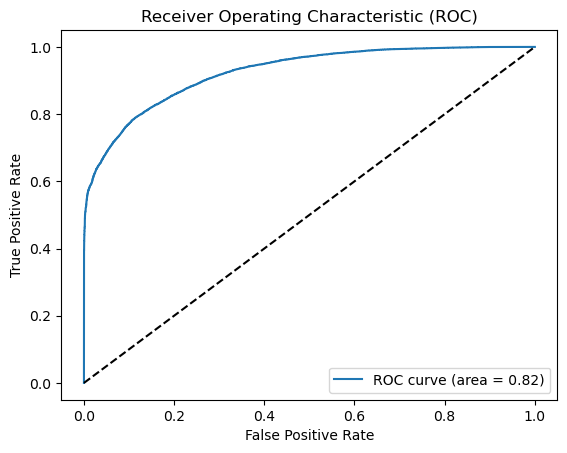

Confusion Matrix:
 [[ 7187  2433]
 [ 1776 14524]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.75      0.77      9620
           1       0.86      0.89      0.87     16300

    accuracy                           0.84     25920
   macro avg       0.83      0.82      0.82     25920
weighted avg       0.84      0.84      0.84     25920


ROC-AUC:  0.8190661709373365

F1 score:  0.8734401780076376


In [12]:
build_and_evaluate_model(imputed_train_df[num_cols + cat_cols], imputed_train_df.Healthy)

In [37]:
imputed_test_df.to_csv('/kaggle/working/imputed_test_df.csv')

In [11]:
imputed_test_df = pd.read_csv('/kaggle/input/sa-hackathon/imputed_test_df.csv')
pred = model.predict(imputed_test_df[num_cols + cat_cols])
submission = pd.DataFrame({'predictions': pred})
submission.to_csv('/kaggle/working/submission_anindya2.csv', index = False)